In [533]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

%matplotlib inline
#np.random.seed(0)
ROWS = 4
COLUMNS = 12
GAMMA = 0.9
ALPHA = 0.4
BETA = 0.7
ENV_EPS = 0.5
STEP = 1000
EPISODES = 5000
EXPERIMENTS = 100

In [534]:
class GridWorld():
    
    def __init__(self, rows, columns):
        self.rows = rows
        self.columns = columns
        self.grid = {}
        self.state = 0
        self.actions = [0,1,2,3]
    
    def reset(self):
        self.state = 0
        return self.state
    
    def set_reward(self, info):
        for i in xrange(self.rows):
            for j in xrange(self.columns):
                self.grid[i * self.columns + j] = [-1, 0]
                          
        for state, reward,done in info:
            self.grid[state] = [reward, done]
        
    def step(self, action):
        #  up: 0
        #down: 1
        #left: 2
        #right: 3
        state = self.state
        if self.state in range(1, 11):
            self.state = 0
        elif action == 0 and self.state >= self.columns:
            self.state -= self.columns
        elif action == 1 and self.state < (self.rows-1)*self.columns:
            self.state += self.columns
        elif action == 2 and self.state % self.columns != 0:
            self.state -= 1
        elif action == 3 and self.state % self.columns != self.columns - 1:
            self.state += 1
            
        return self.state, self.grid[state][0], self.grid[state][1] 
    
    def stochastic_step(self, action):# to make the environment more complex, turns out not a good idea
        rand = random.random()
        if rand < ENV_EPS:
            return self.step(action)
        else:
            action = random.choice(self.actions)
            return self.step(action)
        

In [535]:
class QAgent(object):
    def __init__(self, rows, columns):
        self.Q_values = np.zeros((rows * columns, 4))
        self.epsilon = 0.1
        self.actions = [0,1,2,3]
    
    def choose_eps_greedy(self, state):
        rand = random.random()
        if rand < self.epsilon:
            return random.choice(self.actions)
        else:
            return np.argmax(self.Q_values[state, :])
    def update(self, state, action, next_state, reward):
        pass

In [536]:
class SARSA(QAgent):
    def __init__(self, rows, columns):
        super(SARSA,self).__init__(rows, columns)
    def update(self, state, action, next_state, reward):
        next_action = self.choose_eps_greedy(next_state)
        self.Q_values[state, action] += ALPHA * (reward + GAMMA * \
                self.Q_values[next_state, next_action] - self.Q_values[state, action]) 
        return next_action
class ESARSA(QAgent):
    def __init__(self, rows, columns):
        super(ESARSA,self).__init__(rows, columns)
    def update(self, state, action, next_state, reward):
        maxIndex = np.argmax(esarsa.Q_values[next_state, :])
        self.Q_values[state, action] +=  (reward + GAMMA*\
                ((1 - self.epsilon + self.epsilon/4) * max(self.Q_values[next_state, :]) \
                 +self.epsilon/4 * sum([self.Q_values[next_state, a] for a in xrange(4) if a != maxIndex])) \
                    - self.Q_values[state, action])
class Qlearning(QAgent):
    def __init__(self, rows, columns):
        super(Qlearning,self).__init__(rows, columns)
    def update(self, state, action, next_state, reward):
        self.Q_values[state, action] += ALPHA * (reward + GAMMA * \
                max(self.Q_values[next_state, :]) - self.Q_values[state, action]) 

In [537]:
class PolicyAgent():
    def __init__(self, rows, columns):
        self.state_values = np.zeros((rows*columns, 1))
        self.preference = np.zeros((rows*columns, 4))
        self.actions = [0,1,2,3]
        self.policy = 1./len(self.actions) * np.ones((rows*columns, 4))
    def softmax_policy(self, state):
        exp_sum = sum([math.exp(self.preference[state][j]) for j in xrange(4)])
        for i in xrange(4):
            self.policy[state][i] = 1. * math.exp(self.preference[state][i])/ exp_sum
        return np.random.choice(self.actions, 1, p = self.policy[state])[0]
    
    def update(self, state, action, next_state, reward):
        delta = reward + GAMMA * self.state_values[next_state] - self.state_values[state]
        self.state_values[state] += 0.2 * delta
        for i in self.actions:
            if i == action:
                self.preference[state][i] += BETA * delta * (1-self.policy[state][i])
            else:
                self.preference[state][i] += BETA * delta * (-self.policy[state][i])
        

In [538]:
def smoothing(result, batch):#smooth the curves in the plot by averaging local batch
    new_result = []
    for i in xrange(len(result)/batch):
        average = 1.*sum(result[batch * i: batch * i+batch])/batch
        new_result.append(average)
    return new_result

In [553]:
def showQ(Q, name): #visualization of Q-table
    actions_grid = Q.argmax(1).reshape((4, 12))
    values_grid = Q.max(1).reshape((4, 12))

    actions_xys = np.array([
        [0, 1], #U
        [0, -1], #D
        [-1, 0], #L
        [1, 0], #R
    ])

    actions_x_grid = actions_xys[actions_grid, 0]
    actions_y_grid = actions_xys[actions_grid, 1]
    
    quiver_filter = []
    for i in xrange(Q.shape[0]):
        temp = Q[i,0]
        flag = 0
        for j in xrange(Q.shape[1]):
            if Q[i, j] != temp:
                flag = 1
        if not flag:    
            quiver_filter.append((i/12, i %12))
    for i in xrange(len(quiver_filter)):
        actions_x_grid[quiver_filter[i][0], quiver_filter[i][1]] = 0
        actions_y_grid[quiver_filter[i][0], quiver_filter[i][1]] = 0
    plt.figure()
    plt.imshow(values_grid, interpolation='nearest')
    plt.xlabel(name)
    plt.quiver(actions_x_grid, actions_y_grid)
    
    plt.xticks([]) 
    plt.yticks([])

In [555]:
def showV(V, name):#visualization of value-table
    values_grid = V.reshape((4, 12))

    plt.figure()
    plt.imshow(values_grid, interpolation='nearest')
    plt.xlabel(name)
    plt.xticks([]) 
    plt.yticks([])

In [541]:
#making enviroment
env = GridWorld(ROWS, COLUMNS)
info = []
for i in xrange(1, 11):
    info.append((i, -50, 0))
info.append((11, 0, 1))
env.set_reward(info)

In [542]:
#Training
qAgent = Qlearning(4, 12)
sarsa = SARSA(4, 12)
esarsa = ESARSA(4, 12)
actor_critic = PolicyAgent(4, 12)

q_reward = []
sarsa_reward = []
esarsa_reward = []
actor_critic_reward = []
q_step = []
sarsa_step = []
esarsa_step = []
actor_critic_step = []
for i in xrange(EPISODES):
    #sarsa
    state = env.reset()
    r = 0
    action = sarsa.choose_eps_greedy(state)
    for j in xrange(STEP):
        next_state, reward, done = env.step(action)
        next_action = sarsa.update(state, action, next_state, reward)
        r += reward 
        if done:
            sarsa.Q_values[next_state, :] = 0
            break
        state = next_state
        action = next_action
    sarsa_reward.append(r)
    sarsa_step.append(j)

    #expected-sarsa
    state = env.reset()
    r = 0
    for j in xrange(STEP):
        action = esarsa.choose_eps_greedy(state)
        next_state, reward, done = env.step(action)
        esarsa.update(state, action, next_state, reward)
        r += reward
        if done:
            esarsa.Q_values[next_state, :] = 0
            break
        state = next_state
    esarsa_reward.append(r)
    esarsa_step.append(j)

    
    #Q-learning
    state = env.reset()
    r = 0
    for j in xrange(STEP):
        action = qAgent.choose_eps_greedy(state)
        next_state, reward, done = env.step(action)
        qAgent.update(state, action, next_state, reward)
        r += reward
        if done:
            qAgent.Q_values[next_state, :] = 0
            break
        state = next_state
    q_reward.append(r)
    q_step.append(j)
    #actor-crtic
    state = env.reset()
    r = 0
    j = 0
    for j in xrange(STEP):
        action = actor_critic.softmax_policy(state)
        next_state, reward, done = env.step(action)
        actor_critic.update(state, action, next_state, reward)
        r += reward
        if done:
            qAgent.Q_values[next_state, :] = 0
            break
        state = next_state
    actor_critic_reward.append(r)
    actor_critic_step.append(j)
    
    print "Episodes: ", i

Episodes:  0
Episodes:  1
Episodes:  2
Episodes:  3
Episodes:  4
Episodes:  5
Episodes:  6
Episodes:  7
Episodes:  8
Episodes:  9
Episodes:  10
Episodes:  11
Episodes:  12
Episodes:  13
Episodes:  14
Episodes:  15
Episodes:  16
Episodes:  17
Episodes:  18
Episodes:  19
Episodes:  20
Episodes:  21
Episodes:  22
Episodes:  23
Episodes:  24
Episodes:  25
Episodes:  26
Episodes:  27
Episodes:  28
Episodes:  29
Episodes:  30
Episodes:  31
Episodes:  32
Episodes:  33
Episodes:  34
Episodes:  35
Episodes:  36
Episodes:  37
Episodes:  38
Episodes:  39
Episodes:  40
Episodes:  41
Episodes:  42
Episodes:  43
Episodes:  44
Episodes:  45
Episodes:  46
Episodes:  47
Episodes:  48
Episodes:  49
Episodes:  50
Episodes:  51
Episodes:  52
Episodes:  53
Episodes:  54
Episodes:  55
Episodes:  56
Episodes:  57
Episodes:  58
Episodes:  59
Episodes:  60
Episodes:  61
Episodes:  62
Episodes:  63
Episodes:  64
Episodes:  65
Episodes:  66
Episodes:  67
Episodes:  68
Episodes:  69
Episodes:  70
Episodes:  71
Ep

In [543]:
print "Expected-Sarsa average steps: ", 1. * sum(esarsa_step)/(EPISODES)
print "Sarsa average steps: ", 1. * sum(sarsa_step)/(EPISODES)
print "Actor-Critic average steps: ", 1. * sum(actor_critic_step)/(EPISODES)
print "Q-learning average steps: ", 1. * sum(q_step)/(EPISODES)

sarsa_step = smoothing(sarsa_step, 100)
esarsa_step = smoothing(esarsa_step, 100)
q_step = smoothing(q_step, 100)
actor_critic_step = smoothing(actor_critic_step, 100)

Expected-Sarsa average steps:  17.6896
Sarsa average steps:  20.5022
Actor-Critic average steps:  17.3678
Q-learning average steps:  18.053


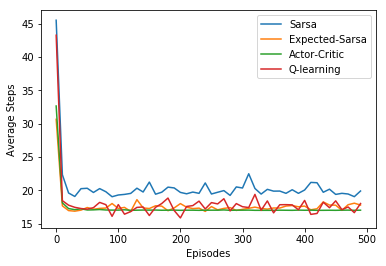

In [544]:
plt.plot(range(0,500, 10),sarsa_step, label = 'Sarsa')
plt.plot(range(0,500, 10),esarsa_step, label = 'Expected-Sarsa')
plt.plot(range(0,500, 10),actor_critic_step, label = 'Actor-Critic')
plt.plot(range(0,500, 10),q_step, label = 'Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Average Steps')
#plt.ylim((-100,0))
plt.legend()
plt.show()

In [545]:
print "Expected-Sarsa average reward: ", 1. * sum(esarsa_reward)/(EPISODES)
print "Sarsa average reward: ", 1. * sum(sarsa_reward)/(EPISODES)
print "Actor-Critic average reward: ", 1. * sum(actor_critic_reward)/(EPISODES)
print "Q-learning average reward: ", 1. * sum(q_reward)/(EPISODES)

sarsa_reward = smoothing(sarsa_reward, 100)
esarsa_reward = smoothing(esarsa_reward, 100)
q_reward = smoothing(q_reward, 100)
actor_critic_reward = smoothing(actor_critic_reward, 100)

Expected-Sarsa average reward:  -20.3748
Sarsa average reward:  -23.55
Actor-Critic average reward:  -17.652
Q-learning average reward:  -34.9776


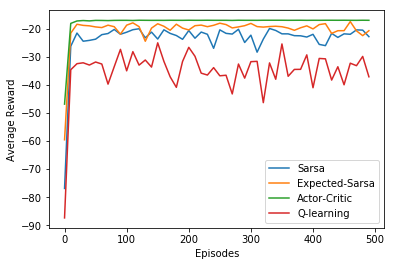

In [546]:
plt.plot(range(0,500, 10),sarsa_reward, label = 'Sarsa')
plt.plot(range(0,500, 10),esarsa_reward, label = 'Expected-Sarsa')
plt.plot(range(0,500, 10),actor_critic_reward, label = 'Actor-Critic')
plt.plot(range(0,500, 10),q_reward, label = 'Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
#plt.ylim((-100,0))
plt.legend()
plt.show()

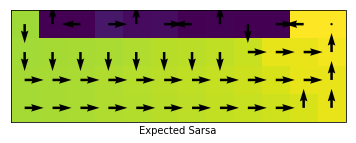

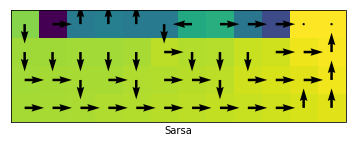

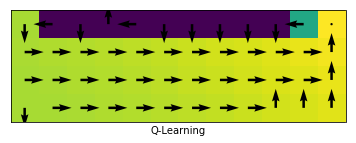

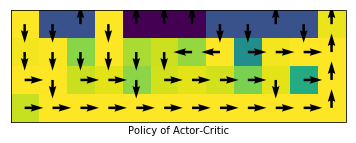

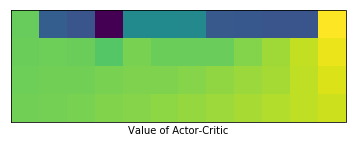

In [556]:
showQ(esarsa.Q_values, "Expected Sarsa")
showQ(sarsa.Q_values, "Sarsa")
showQ(qAgent.Q_values,"Q-Learning")
showQ(actor_critic.policy,"Policy of Actor-Critic")
showV(actor_critic.state_values, "Value of Actor-Critic")
